# 文本分类实验

## 实验目标
本次实验的目标是使用 GBDT 对文本数据进行分类，并通过数据增强、特征工程和模型调优提升性能。输出指标包括：
- 宏平均（Macro Average）
- 微平均（Micro Average）
- 混淆矩阵

## 数据集
使用的数据集来自 `filtered_cnews.train.txt` 文件，包含以下类别：
- 体育
- 家居
- 房产
- 教育
- 科技
- 财经

数据集被划分为：
- 训练集：每个类别 4000 条
- 验证集：每个类别 500 条
- 测试集：每个类别 500 条

## 1.导入库

In [1]:
# 导入必要的库
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

## 2.加载数据

In [2]:
# 定义一个函数来加载数据
def load_data_from_file(file_path):
    texts = []  # 存储所有文本内容
    labels = []  # 存储对应的类别标签
    
    # 打开文件并逐行读取
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:  # 遍历文件中的每一行
            line = line.strip()  # 去除行首和行尾的空白字符
            
            # 检查行是否为空
            if not line:
                continue
            
            # 按制表符分割类别和文本内容
            try:
                label, text = line.split('\t', 1)  # 使用 '\t' 分割，最多分割一次
            except ValueError:
                print(f"无法解析行: {line}")  # 如果分割失败，打印提示信息
                continue
            
            # 将类别和文本内容添加到列表中
            texts.append(text)
            labels.append(label)
    
    return texts, labels  # 返回文本内容和对应的类别标签

# 设置数据文件路径
data_file = "filtered_cnews.train.txt" 

# 加载数据
texts, labels = load_data_from_file(data_file)

# 查看前几条数据
print("前5条文本内容:")
for i in range(5):
    print(f"类别: {labels[i]} | 文本: {texts[i][:50]}...")  # 打印前50个字符

前5条文本内容:
类别: 体育 | 文本: 马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有摆脱雨水...
类别: 体育 | 文本: 商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也来了。距...
类别: 体育 | 文本: 冠军球队迎新欢乐派对 黄旭获大奖张军赢下PK赛新浪体育讯12月27日晚，“冠军高尔夫球队迎新高球欢乐...
类别: 体育 | 文本: 辽足签约危机引注册难关 高层威逼利诱合同笑里藏刀新浪体育讯2月24日，辽足爆发了集体拒签风波，不签合...
类别: 体育 | 文本: 揭秘谢亚龙被带走：总局电话骗局 复制南杨轨迹体坛周报特约记者张锐北京报道  谢亚龙已经被公安部门正式...


## 3.按类别划分数据集

In [3]:
# 获取所有类别
unique_labels = np.unique(labels)

# 初始化存储划分后的数据
X_train_all, y_train_all = [], []
X_val_all, y_val_all = [], []
X_test_all, y_test_all = [], []

# 按类别划分数据集
for label in unique_labels:
    # 获取当前类别的文本和标签
    class_texts = [text for text, lbl in zip(texts, labels) if lbl == label]
    class_labels = [lbl for lbl in labels if lbl == label]
    
    # 确保每个类别的样本数量足够
    assert len(class_texts) >= 5000, f"类别 {label} 的样本不足 5000 条，请检查输入文件！"
    
    # 划分当前类别的数据集
    X_train, X_temp, y_train, y_temp = train_test_split(class_texts, class_labels, test_size=1000, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=500, random_state=42)
    
    # 将当前类别的数据添加到全局数据集中
    X_train_all.extend(X_train)
    y_train_all.extend(y_train)
    X_val_all.extend(X_val)
    y_val_all.extend(y_val)
    X_test_all.extend(X_test)
    y_test_all.extend(y_test)

# 输出划分结果
print(f"训练集样本数: {len(X_train_all)}")
print(f"验证集样本数: {len(X_val_all)}")
print(f"测试集样本数: {len(X_test_all)}")

训练集样本数: 24000
验证集样本数: 3000
测试集样本数: 3000


## 4.特征工程

In [4]:
# 使用 TF-IDF 提取特征，并添加 bigram
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # 包括 unigram 和 bigram
X_train = vectorizer.fit_transform(X_train_all)
X_val = vectorizer.transform(X_val_all)
X_test = vectorizer.transform(X_test_all)

# 使用 SMOTE 进行过采样
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.toarray(), y_train_all)

# 转换回稀疏矩阵
X_train_resampled = csr_matrix(X_train_resampled)

## 5.训练模型（朴素贝叶斯）


朴素贝叶斯分类报告:
              precision    recall  f1-score   support

          体育       0.58      0.95      0.72       500
          家居       0.75      0.28      0.41       500
          房产       0.86      0.86      0.86       500
          教育       0.75      0.77      0.76       500
          科技       0.87      0.81      0.84       500
          财经       0.76      0.77      0.77       500

    accuracy                           0.74      3000
   macro avg       0.76      0.74      0.72      3000
weighted avg       0.76      0.74      0.72      3000


朴素贝叶斯混淆矩阵:
[[474   1   7   4   6   8]
 [290 139  17  32   8  14]
 [  4   3 432   7   3  51]
 [ 18  24  12 384  28  34]
 [ 22  11   5  39 406  17]
 [ 15   7  31  46  14 387]]


C:\Users\Zhou Liying\.conda\envs\env1\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Zhou Liying\.conda\envs\env1\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 32946 (\N{CJK UNIFIED IDEOGRAPH-80B2}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Zhou Liying\.conda\envs\env1\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Zhou Liying\.conda\envs\env1\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 23621 (\N{CJK UNIFIED IDEOGRAPH-5C45}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Zhou Liying\.conda\envs\env1\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 25151 (\N{CJK UNIFIED IDEOGRAPH-623F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Zhou Liying\.conda\envs\env1\Lib\site-packages

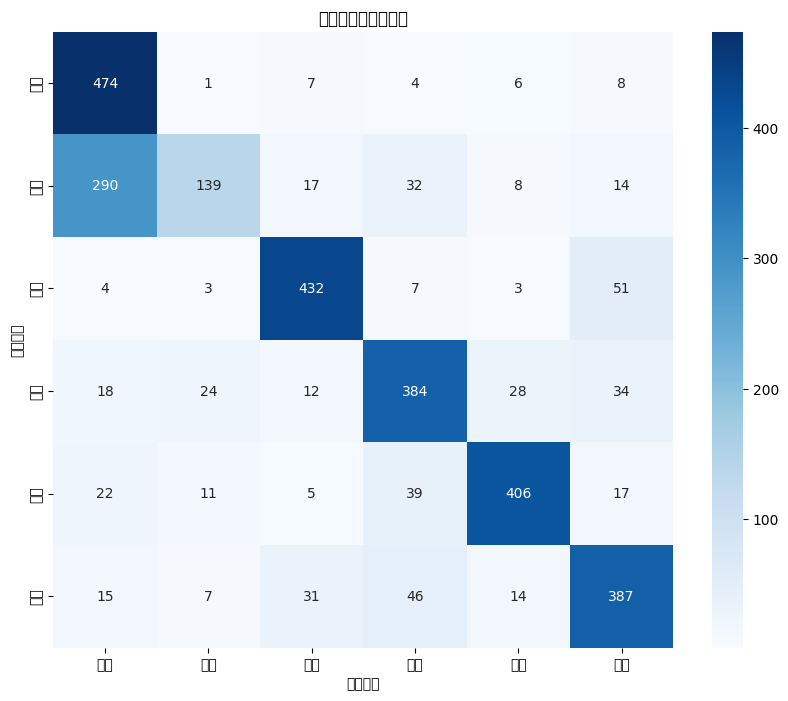

In [5]:
# 初始化朴素贝叶斯分类器
nb_classifier = MultinomialNB()

# 使用训练集训练模型
nb_classifier.fit(X_train_resampled, y_train_resampled)

# 在测试集上进行预测
y_test_pred_nb = nb_classifier.predict(X_test)

# 输出朴素贝叶斯的分类报告
print("\n朴素贝叶斯分类报告:")
print(classification_report(y_test_all, y_test_pred_nb))

# 输出朴素贝叶斯的混淆矩阵
cm_nb = confusion_matrix(y_test_all, y_test_pred_nb, labels=unique_labels)
print("\n朴素贝叶斯混淆矩阵:")
print(cm_nb)

# 可视化混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("预测类别")
plt.ylabel("真实类别")
plt.title("朴素贝叶斯混淆矩阵")
plt.show()

## 6.训练模型（GBDT）

GBDT 最佳参数: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

GBDT 分类报告:
              precision    recall  f1-score   support

          体育       0.99      0.88      0.93       500
          家居       0.61      0.94      0.74       500
          房产       0.99      0.96      0.97       500
          教育       0.71      0.67      0.69       500
          科技       0.94      0.72      0.82       500
          财经       0.83      0.73      0.77       500

    accuracy                           0.82      3000
   macro avg       0.84      0.82      0.82      3000
weighted avg       0.84      0.82      0.82      3000


GBDT 混淆矩阵:
[[438  34   0  18   0  10]
 [  2 471   0  22   1   4]
 [  0   8 480   0   1  11]
 [  0 120   2 333  14  31]
 [  3  64   3  48 361  21]
 [  1  75   2  50   7 365]]


C:\Users\Zhou Liying\.conda\envs\env1\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Zhou Liying\.conda\envs\env1\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 32946 (\N{CJK UNIFIED IDEOGRAPH-80B2}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Zhou Liying\.conda\envs\env1\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Zhou Liying\.conda\envs\env1\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 23621 (\N{CJK UNIFIED IDEOGRAPH-5C45}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Zhou Liying\.conda\envs\env1\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 25151 (\N{CJK UNIFIED IDEOGRAPH-623F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Zhou Liying\.conda\envs\env1\Lib\site-packages

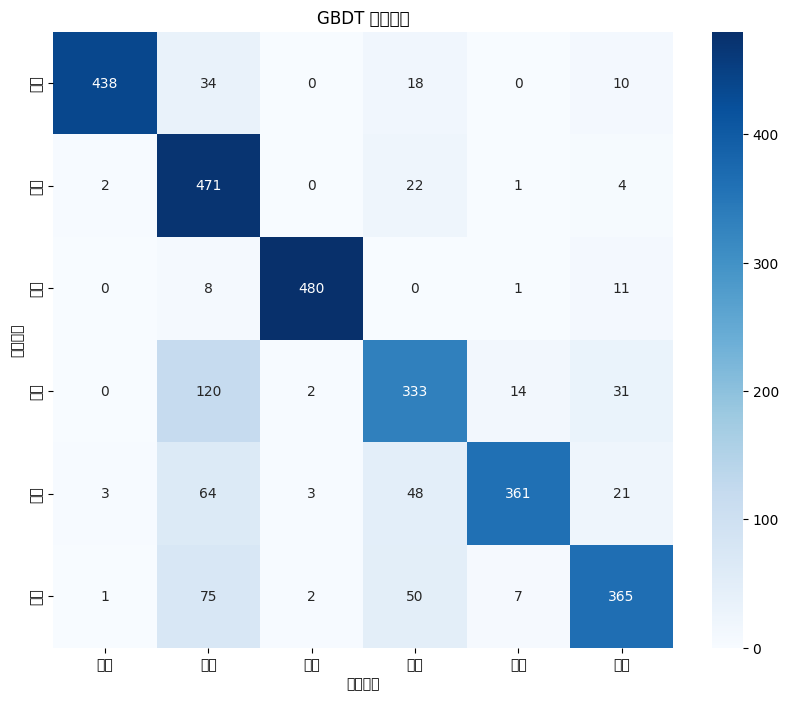

In [6]:
# 定义参数网格
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

# 使用网格搜索调优 GBDT
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train_resampled, y_train_resampled)

# 输出最佳参数
print("GBDT 最佳参数:", grid_search.best_params_)

# 使用最佳参数重新训练模型
gbdt_classifier = grid_search.best_estimator_
y_test_pred_gbdt = gbdt_classifier.predict(X_test)

# 输出 GBDT 的分类报告
print("\nGBDT 分类报告:")
print(classification_report(y_test_all, y_test_pred_gbdt))

# 输出 GBDT 的混淆矩阵
cm_gbdt = confusion_matrix(y_test_all, y_test_pred_gbdt, labels=unique_labels)
print("\nGBDT 混淆矩阵:")
print(cm_gbdt)

# 可视化混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm_gbdt, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("预测类别")
plt.ylabel("真实类别")
plt.title("GBDT 混淆矩阵")
plt.show()

## 7.错误分析

In [7]:
# 找出测试集中被错误分类的样本
errors_nb = [(true, pred, text) for true, pred, text in zip(y_test_all, y_test_pred_nb, X_test_all) if true != pred]
errors_gbdt = [(true, pred, text) for true, pred, text in zip(y_test_all, y_test_pred_gbdt, X_test_all) if true != pred]

# 打印朴素贝叶斯前 10 个错误样本
print("朴素贝叶斯前10个错误分类样本:")
for true, pred, text in errors_nb[:10]:
    print(f"真实类别: {true} | 预测类别: {pred} | 文本: {text[:100]}...")

# 打印 GBDT 前 10 个错误样本
print("\nGBDT 前10个错误分类样本:")
for true, pred, text in errors_gbdt[:10]:
    print(f"真实类别: {true} | 预测类别: {pred} | 文本: {text[:100]}...")

朴素贝叶斯前10个错误分类样本:
真实类别: 体育 | 预测类别: 房产 | 文本: 江苏山东到底谁娱乐了谁？媒体“互殴”击中要害就在新年之际，军粤大战以一场无悬念、一边倒的比赛默默地过了年；反倒是江苏跟山东这边，过得轰轰烈烈、热热闹闹。一场媒体间的口水仗，让大家伙都在新年里，“娱乐”...
真实类别: 体育 | 预测类别: 科技 | 文本: 科比球鞋6代今日正式发布 黑曼巴出击无情掠食(图)新浪体育讯俄勒冈州比佛顿(2010年12月07日)—耐克(纽约证交所代码：NKE)与科比·布莱恩特今日正式发布Nike Zoom Kobe VI 篮球...
真实类别: 体育 | 预测类别: 教育 | 文本: 掘金自毁前程被逼入死角 甜瓜去纽约其实毫无悬念新浪体育讯北京时间1月24日，据美国权威体育媒体《Sporting News(体育新闻)》报道，在篮网宣布正式放弃卡梅罗-安东尼之后，尽管事情变得更加复杂...
真实类别: 体育 | 预测类别: 房产 | 文本: 土耳其邀请赛U16国少开门红 25分大胜保加利亚队新浪体育讯北京时间2月6日，2011年土耳其U16国际邀请赛结束了第一天的赛程，中国U16国少队在首战中以91比66击败保加利亚队，取得了本次邀请赛上...
真实类别: 体育 | 预测类别: 财经 | 文本: 辽宁召回被裁外援史密斯 郭士强为何要吃回头草？刘爱琳今日19：30，广东东莞银行将在中山主场迎战辽宁男篮，此前两轮均以全华班出战的客队阵容又有了新的变化。昨天，从辽宁队传出消息，球队已召回了此前裁掉的...
真实类别: 体育 | 预测类别: 财经 | 文本: 谢亚龙落网牵出神秘天之择 夫妻运作培训费遭举报体坛周报特约记者张锐报道 谢亚龙被立案后，关于他被查的起因是什么，各种传言层出不穷。记者从权威渠道了解到，起因还是与传说中2008年的一笔培训费用有关；而...
真实类别: 体育 | 预测类别: 教育 | 文本: 博士蛙将NBA带进中国家庭 将办NBA主题儿童嘉年华新浪体育讯北京时间3月28日消息，NBA与博士蛙集团今天在北京JW万豪酒店新闻厅召开新闻发布会，宣布将进一步提升双方现有合作，博士蛙正式成为NBA官...
真实类别: 体育 | 预测类别: 财经 | 文本: 75%三分命中率绝非靠蒙 热火有一人打死不可放出手比赛一开始查尔默斯表现一般，首节剩下4分钟的